In [ ]:
!pip install transformers

In [ ]:
import torch
import re
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.optim import AdamW
from transformers import Trainer, TrainingArguments
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# This is the name of the program management system for NVIDIA GPUs. We're going to send our code here.

device_name = 'cuda'

# This is the name of the directory where we'll save our model. You can name it whatever you want.
cached_model_directory_name = 'GPT2_text_generation_model_paritosh'

In [ ]:
# Generate text example using gpt2 model
generator = pipeline('text-generation', model='gpt2')
set_seed(101)
generator("Harry and Bilbo ", max_length=100, num_return_sequences=2)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Harry and Bilbo \xa0who has also seen the "torture chamber" and the way he is punished for the murders at the hands of the Scoobies and Hobbits: The two of them seem to have spent some time together during this time.\nMoldy makes an appearance to tell Hobbits that his death has been avoided for quite some time, something Hobbits and Elves have been afraid of ever before and especially about this time. It is clear from this that it is'},
 {'generated_text': "Harry and Bilbo \xa0and to continue to build the kingdom along with their own little kingdom together. As they make their way through the Kingdom of the Sun, the Princess of the Sands, and further adventures, they discover a new location and a new kingdom within the kingdoms of the lands which were once the world's most powerful cities.\nSo far we see the adventures of Princess Bilius and Princess Nilias, although in the main there are many more than one. While there may"}]

In [ ]:
#Data Loading and Data Cleaning
script_files = [
                "/kaggle/input/books-dataset-text-generation/HarryPotter1.txt",
                "/kaggle/input/books-dataset-text-generation/Hobbit1.txt",
                "/kaggle/input/books-dataset-text-generation/HarryPotter2.txt",
                "/kaggle/input/books-dataset-text-generation/LOTR1.txt",
                "/kaggle/input/books-dataset-text-generation/HarryPotter3.txt",
                "/kaggle/input/books-dataset-text-generation/LOTR2.txt",
                "/kaggle/input/books-dataset-text-generation/HarryPotter4.txt",
                "/kaggle/input/books-dataset-text-generation/LOTR3.txt",
                "/kaggle/input/books-dataset-text-generation/HarryPotter5.txt",
                "/kaggle/input/books-dataset-text-generation/Silmarillion4.txt",
                "/kaggle/input/books-dataset-text-generation/HarryPotter6.txt",
                "/kaggle/input/books-dataset-text-generation/HarryPotter7.txt"
]
text_data=""
for script in script_files:
    with open(script, 'r') as file:
        text = file.read()
        text = re.sub(r"[^\w\s.,']", "", text)
        text = re.sub(r"\s+", " ", text)
        text_data=text_data+text
        text_data = text_data.strip()
        file.close()
#Save cleaned data in a text file
data_file = open('/kaggle/working/cleaned_text_data.txt', 'w')
data_file.write(text_data)
data_file.close()

In [ ]:
#Location of cleaned data
data_file= '/kaggle/working/cleaned_text_data.txt'

In [ ]:
#Size of text data
len(text_data)

9716362

In [ ]:
#Load the tokenizer for GPT2 model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
#Tokenize the dataset
dataset = TextDataset(tokenizer=tokenizer,file_path=data_file,block_size=128)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,mlm=False)
## This block of code will be included in defined functions below.

/opt/conda/lib/python3.10/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [ ]:
#Define function to load and tokenize the dataset
def load_dataset(file_path, tokenizer, block_size = 128):
    dataset = TextDataset(
        tokenizer = tokenizer,
        file_path = file_path,
        block_size = block_size,
    )
    return dataset

#Function to load data collator for language modelling
def load_data_collator(tokenizer, mlm = False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=mlm,
    )
    return data_collator

#Function to train the model
tokenizer = None
model = None
trainer = None

def train(train_file_path,model_name,output_dir,overwrite_output_dir,
          per_device_train_batch_size,
          num_train_epochs,learning_rate):

    global tokenizer
    global model
    global trainer

    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    train_dataset = load_dataset(train_file_path, tokenizer)
    data_collator = load_data_collator(tokenizer)

    tokenizer.save_pretrained(output_dir)

    model = GPT2LMHeadModel.from_pretrained(model_name).to(device_name)

    #Define training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=overwrite_output_dir,
        per_device_train_batch_size=per_device_train_batch_size,
        num_train_epochs=num_train_epochs,logging_steps=100, learning_rate = learning_rate)
    #Trainer function to train the model
    trainer = Trainer(model=model,args=training_args,data_collator=data_collator,train_dataset=train_dataset)

    trainer.train()
    #Save the model
    # trainer.save_model()
    return trainer





In [ ]:
#Setting parameters
train_file_path = data_file
model_name = 'gpt2'
output_dir = 'saved_model'
overwrite_output_dir = True
per_device_train_batch_size = 32
num_train_epochs = 11
learning_rate = 0.0001

In [ ]:
#Calling train function to train the model
print("Learning Rate = ", learning_rate)
trainer = train(train_file_path=train_file_path,model_name=model_name,
                output_dir=output_dir,
                overwrite_output_dir=overwrite_output_dir,
                per_device_train_batch_size=per_device_train_batch_size,
                num_train_epochs=num_train_epochs, learning_rate=learning_rate)

trainer.save_model()

Learning Rate =  0.0001


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
100,3.880400
200,3.730200
300,3.667900
400,3.632700
500,3.600000
600,3.511200
700,3.426300
800,3.426600
900,3.420200
1000,3.404300


In [ ]:
#Print the model training logs
trainer.state.log_history

[{'loss': 3.8804,
  'learning_rate': 9.834409670475245e-05,
  'epoch': 0.18,
  'step': 100},
 {'loss': 3.7302,
  'learning_rate': 9.668819340950489e-05,
  'epoch': 0.36,
  'step': 200},
 {'loss': 3.6679,
  'learning_rate': 9.503229011425733e-05,
  'epoch': 0.55,
  'step': 300},
 {'loss': 3.6327,
  'learning_rate': 9.337638681900977e-05,
  'epoch': 0.73,
  'step': 400},
 {'loss': 3.6,
  'learning_rate': 9.172048352376222e-05,
  'epoch': 0.91,
  'step': 500},
 {'loss': 3.5112,
  'learning_rate': 9.006458022851466e-05,
  'epoch': 1.09,
  'step': 600},
 {'loss': 3.4263,
  'learning_rate': 8.84086769332671e-05,
  'epoch': 1.28,
  'step': 700},
 {'loss': 3.4266,
  'learning_rate': 8.675277363801954e-05,
  'epoch': 1.46,
  'step': 800},
 {'loss': 3.4202,
  'learning_rate': 8.509687034277199e-05,
  'epoch': 1.64,
  'step': 900},
 {'loss': 3.4043,
  'learning_rate': 8.344096704752443e-05,
  'epoch': 1.82,
  'step': 1000},
 {'loss': 3.3916,
  'learning_rate': 8.178506375227687e-05,
  'epoch': 2.

In [ ]:
#Store steps, loss and epochs data from training logs
steps = []
loss =[]
epochs=[]
for i in range(len(trainer.state.log_history)):
    steps.append(trainer.state.log_history[i]["step"])
for i in range(len(trainer.state.log_history)):
    epochs.append(trainer.state.log_history[i]["epoch"])


In [ ]:
for i in range(len(trainer.state.log_history)-1):
    loss.append(trainer.state.log_history[i]["loss"])
loss.append(trainer.state.log_history[len(trainer.state.log_history)-1]["train_loss"])

In [ ]:
print(epochs,steps, loss)

[0.18, 0.36, 0.55, 0.73, 0.91, 1.09, 1.28, 1.46, 1.64, 1.82, 2.0, 2.19, 2.37, 2.55, 2.73, 2.91, 3.1, 3.28, 3.46, 3.64, 3.83, 4.01, 4.19, 4.37, 4.55, 4.74, 4.92, 5.1, 5.28, 5.46, 5.65, 5.83, 6.01, 6.19, 6.38, 6.56, 6.74, 6.92, 7.1, 7.29, 7.47, 7.65, 7.83, 8.01, 8.2, 8.38, 8.56, 8.74, 8.93, 9.11, 9.29, 9.47, 9.65, 9.84, 10.02, 10.2, 10.38, 10.56, 10.75, 10.93, 11.0] [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6039] [3.8804, 3.7302, 3.6679, 3.6327, 3.6, 3.5112, 3.4263, 3.4266, 3.4202, 3.4043, 3.3916, 3.2665, 3.2674, 3.2794, 3.276, 3.2607, 3.2126, 3.1608, 3.159, 3.1591, 3.1669, 3.1622, 3.0527, 3.0664, 3.0785, 3.0817, 3.0798, 3.0319, 2.987, 3.0053, 3.01, 3.0022, 2.9948, 2.9213, 2.9307, 2.

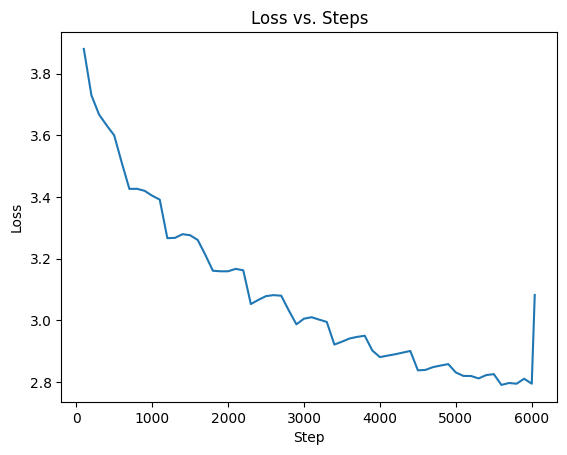

In [ ]:
#Plot the graph of training loss vs steps
plt.plot(steps, loss)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss vs. Steps")
plt.show()

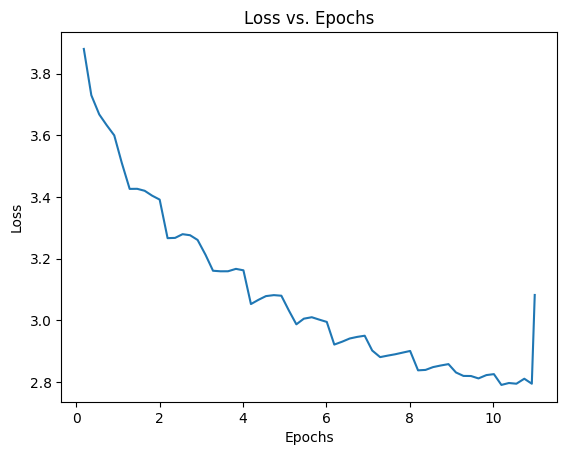

In [ ]:
#Plot the graph of training loss vs epochs
plt.plot(epochs, loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.show()

### Model Evaluation (Model 1)

In [ ]:
# Generate text example
generator = pipeline('text-generation', model="./saved_model")
generator("The story began with Harry Potter, Hermione Granger, and Ron Weasley inadvertently stumbling upon an ancient portal while exploring the Forbidden Forest during their final year at Hogwarts. Upon emerging from the portal, they found themselves in a vast and dense forest, surrounded by towering trees. To their surprise, they were greeted by none other than Frodo, Sam, Merry, and Pippin, the beloved hobbits from the Shire. Harry was surprised to see hobbits and then decided to befriend them ", max_length=1000, num_return_sequences=1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "The story began with Harry Potter, Hermione Granger, and Ron Weasley inadvertently stumbling upon an ancient portal while exploring the Forbidden Forest during their final year at Hogwarts. Upon emerging from the portal, they found themselves in a vast and dense forest, surrounded by towering trees. To their surprise, they were greeted by none other than Frodo, Sam, Merry, and Pippin, the beloved hobbits from the Shire. Harry was surprised to see hobbits and then decided to befriend them ickle. Hi, Sam, he said gruffly, helping himself to coffee. I thought we'd be friends before we went out to the field and started shooting hoops. That sounds great, said Sam when he saw them hurrying toward him as he passed. I wonder what these old socks are made of, eh Yeah, I can, said Merry, smiling. A selection of their socks. D'you reckon they're made of some metal the unicorn would like A bit like them. Can you lend 'em any help, Mr. Frodo I didn't want to help, said Mr. Pipp

### Here again prompt text "Harry" was used to generate text from fine tuned GPT 2 model and we can notice that both of sequences are related to Harry Potter and Hogwartz which shows that our fine tuning process is successful.

In [ ]:
#Generate text example
generator("Frodo decided to face sauron army ", max_length=500, num_return_sequences=2)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Frodo decided to face sauron army ichieren. That would be twelve horsemen or more, the order of battle, and many arrows could he find. He crossed into the open and took a lead towards the enemy before they could meet him. Then he halted, seized his sword Anglachel by the hilt, he charged the goblins with his spear, and seized Merry with his bow and they quailed. At last he halted again and turned his whole force to bear them back. They made no move for battle,intosh of Orcs or of the Orcs that were in the woods. Swiftly Frodo rose and looked down upon them the glint of arrows on their horses but all was plain. The Orcs looked upon their enemy without the least courtesy. 'We did not put a hand on them,' said Aragorn. 'We did not cut them down. There seemed little chance of their escape.' 'Well, how come'said Frodo. I am afraid they fled to a wood beyond sight from here behind,' said the king but the Orcs did not pursue them or yield to newest attack, neither did the

## push to hub

In [ ]:
pip install huggingface_hub

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
model.save_pretrained(cached_model_directory_name)

In [ ]:
type(model)

transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel

In [ ]:
model.push_to_hub(cached_model_directory_name)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Prashant-karwasra/GPT2_text_generation_model_paritosh/commit/bc510562f117c96ab6b8b6b21ea8d236092c0301', commit_message='Upload model', commit_description='', oid='bc510562f117c96ab6b8b6b21ea8d236092c0301', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub(cached_model_directory_name)

CommitInfo(commit_url='https://huggingface.co/Prashant-karwasra/GPT2_text_generation_model_paritosh/commit/1170969217f22962423366c31fab4ddb6c96e45f', commit_message='Upload tokenizer', commit_description='', oid='1170969217f22962423366c31fab4ddb6c96e45f', pr_url=None, pr_revision=None, pr_num=None)